In [23]:
import numpy as np
import matplotlib.pyplot as plt 
import qiskit as qk
qk.IBMQ.load_account()

/home/heineaabo/.local/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [82]:
class Model:
    def __init__(self,n_work,n_simulation,n_ancilla,Emax,*argv):
        self.w = n_work
        self.s = n_simulation
        self.N = n_work + n_simulation + n_ancilla
        self.qb = qk.QuantumRegister(self.N)
        self.cb = qk.ClassicalRegister(self.N)
        self.qc = qk.QuantumCircuit(self.qb,self.cb)
        self.Emax = Emax
        self.args = argv
    
    def toPhase(self,bitstr):
        phase = 0
        for i,c in enumerate(bitstr):
            phase += (2**(-i-1))*int(c)
        return phase
        
    def measure(self):
        self.qc.measure(self.qb,self.cb)
        job = qk.execute(self.qc, backend = qk.Aer.get_backend('qasm_simulator'), shots=1024)
        #qk.tools.monitor.job_monitor(job)
        result = job.result().get_counts(self.qc)
        x = [] # phase
        y = [] # hits
        for key,val in res.items():
            eigenstate = key[:self.N-self.w]
            phi = key[self.N-self.w:]
            print(4*np.pi*self.toPhase(key),4*np.pi*self.toPhase(key[::-1]))
        return result

In [83]:
def simple(Qcirc,w,ctrl,dt):
    qc = Qcirc[0]
    qb = Qcirc[1]
    cb = Qcirc[2]
    
    qc.cx(qb[w],qb[-1])
    qc.cx(qb[w],qb[-1])
    qc.crz(2*dt,qb[ctrl],qb[w+1])
    
    qc.u1(2*dt,qb[ctrl])

    return [qc,qb,cb]

In [84]:
class Pairing(Model):
    def __init__(self,*args):
        super().__init__(*args)
        self.delta = self.args[0]
        self.g = self.args[1]
        self.ansatz()
    
    def __call__(self,control_qubit,dt):
        n_work = self.w
        n_simulation = self.s
        n_qubits = self.N

        qz = self.qc
        qb = self.qb
        
        s_state = 0

        for q_state in range(0,n_simulation):
            if q_state % 2 == 0:
                s_state += 1
            qz.crz(dt*delta*(s_state - 1),qb[control_qubit],qb[q_state+n_work])

            qz.cu1(-dt*delta*(1/8)*(n_simulation-2)*n_simulation,qb[control_qubit],qb[n_work])
            qz.x(qb[n_work])
            qz.cu1(-dt*delta*(1/8)*(n_simulation-2)*n_simulation,qb[control_qubit],qb[n_work])
            qz.x(qb[n_work])

            qz.cu1(Emax*dt,qb[control_qubit],qb[n_work])
            qz.x(qb[n_work])
            qz.cu1(Emax*dt,qb[control_qubit],qb[n_work])
            qz.x(qb[n_work])


            for p in range(1,n_simulation,2):
                for q in range(p,n_simulation,2):
                    if p == q:
                        theta = -2*(1/8)*g*dt
                        qz.cu1(-theta/2,qb[control_qubit],qb[n_work])
                        qz.x(qb[n_work])
                        qz.cu1(-theta/2,qb[control_qubit],qb[n_work])
                        qz.x(qb[n_work])

                        qz.crz(theta,qb[control_qubit],qb[p-1+n_work])
                        qz.crz(theta,qb[control_qubit],qb[p+n_work])

                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.crz(theta,qb[control_qubit],qb[n_qubits-1])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                    else:
                        theta = -2*(1/16)*g*dt
                        #FIRST TERM:
                        qz.h(qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.h(qb[q+n_work])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.crz(theta,qb[control_qubit],qb[n_qubits-1])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.h(qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.h(qb[q+n_work])
                        ############
                        #SECOND TERM:
                        qz.h(qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.rz(np.pi/2,qb[q-1+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.rz(np.pi/2,qb[q+n_work])
                        qz.h(qb[q+n_work])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.crz(-theta,qb[control_qubit],qb[n_qubits-1])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.h(qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.rz(-np.pi/2,qb[q-1+n_work])
                        qz.h(qb[q+n_work])
                        qz.rz(-np.pi/2,qb[q+n_work])
                        ###########
                        #THIRD TERM:
                        qz.h(qb[p-1+n_work])
                        qz.rz(np.pi/2,qb[p+n_work])
                        qz.h(qb[p+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.rz(np.pi/2,qb[q+n_work])
                        qz.h(qb[q+n_work])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.crz(theta,qb[control_qubit],qb[n_qubits-1])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.h(qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.rz(-np.pi/2,qb[p+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.h(qb[q+n_work])
                        qz.rz(-np.pi/2,qb[q+n_work])
                        ###########
                        #FOURTH TERM
                        qz.h(qb[p-1+n_work])
                        qz.rz(np.pi/2,qb[p+n_work])
                        qz.h(qb[p+n_work])
                        qz.rz(np.pi/2,qb[q-1+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.h(qb[q+n_work])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.crz(theta,qb[control_qubit],qb[n_qubits-1])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.h(qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.rz(-np.pi/2,qb[p+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.rz(-np.pi/2,qb[q-1+n_work])
                        qz.h(qb[q+n_work])
                        ###########
                        #FIFTH TERM
                        qz.rz(np.pi/2,qb[p-1+n_work])
                        qz.h(qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.rz(np.pi/2,qb[q+n_work])
                        qz.h(qb[q+n_work])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.crz(theta,qb[control_qubit],qb[n_qubits-1])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.h(qb[p-1+n_work])
                        qz.rz(-np.pi/2,qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.h(qb[q+n_work])
                        qz.rz(-np.pi/2,qb[q+n_work])
                        ##########
                        #SIXTH TERM:
                        qz.rz(np.pi/2,qb[p-1+n_work])
                        qz.h(qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.rz(np.pi/2,qb[q-1+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.h(qb[q+n_work])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.crz(theta,qb[control_qubit],qb[n_qubits-1])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.h(qb[p-1+n_work])
                        qz.rz(-np.pi/2,qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.rz(-np.pi/2,qb[q-1+n_work])
                        qz.h(qb[q+n_work])
                        #######################
                        #SEVENTH TERM
                        qz.rz(np.pi/2,qb[p-1+n_work])
                        qz.h(qb[p-1+n_work])
                        qz.rz(np.pi/2,qb[p+n_work])
                        qz.h(qb[p+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.h(qb[q+n_work])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.crz(-theta,qb[control_qubit],qb[n_qubits-1])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.h(qb[p-1+n_work])
                        qz.rz(-np.pi/2,qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.rz(-np.pi/2,qb[p+n_work])
                        qz.h(qb[q-1+n_work])

                        qz.h(qb[q+n_work])
                        ##############
                        #EIGTH TERM:
                        qz.rz(np.pi/2,qb[p-1+n_work])
                        qz.h(qb[p-1+n_work])
                        qz.rz(np.pi/2,qb[p+n_work])
                        qz.h(qb[p+n_work])
                        qz.rz(np.pi/2,qb[q-1+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.rz(np.pi/2,qb[q+n_work])
                        qz.h(qb[q+n_work])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.crz(theta,qb[control_qubit],qb[n_qubits-1])
                        qz.cx(qb[p-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[p+n_work],qb[n_qubits-1])
                        qz.cx(qb[q-1+n_work],qb[n_qubits-1])
                        qz.cx(qb[q+n_work],qb[n_qubits-1])
                        qz.h(qb[p-1+n_work])
                        qz.rz(-np.pi/2,qb[p-1+n_work])
                        qz.h(qb[p+n_work])
                        qz.rz(-np.pi/2,qb[p+n_work])
                        qz.h(qb[q-1+n_work])
                        qz.rz(-np.pi/2,qb[q-1+n_work])
                        qz.h(qb[q+n_work])
                        qz.rz(-np.pi/2,qb[q+n_work])
        self.qc = qz
        self.qb = qb
        return self
    
    def ansatz(self):
        for i in range(0,self.s,2):
            self.qc.h(self.qb[self.w+i])
            self.qc.cx(self.qb[self.w+i],self.qb[self.w+i+1])
        return None

In [85]:
class Heisenberg(Model):
    def __init__(self,*args):
        super().__init__(*args)
        self.h0 = self.args[0]
        self.ansatz()
    
    def __call__(self,ctrl,dt):
        qc = self.qc
        qb = self.qb
        w = self.w
        h0 = self.h0
        
        ### ONEBODY ###
        #qc.crz(h0*dt,qb[ctrl],qb[w+0])
        #qc.crz(h0*dt,qb[ctrl],qb[w+1])

        ### TWOBODY ###

        #FIRST ROUND

        ##### X #####
        qc.cx(qb[w+1],qb[w+0])
        qc.h(qb[w+1])
        qc.crz(2*dt,qb[ctrl],qb[w+1])
        qc.h(qb[w+1])
        qc.cx(qb[w+1],qb[w+0])
        ##### Y #####
        qc.rz(np.pi/2,qb[w+0])
        qc.rz(np.pi/2,qb[w+1])
        qc.cx(qb[w+1],qb[w+0])
        qc.h(qb[w+1])
        qc.crz(2*dt,qb[ctrl],qb[w+1])
        qc.h(qb[w+1])
        qc.cx(qb[w+1],qb[w+0])
        qc.rz(-np.pi/2,qb[w+0])
        qc.rz(-np.pi/2,qb[w+1])
        ##### Z #####
        qc.cx(qb[w+1],qb[w+0])
        qc.crz(2*dt,qb[ctrl],qb[w+0])
        qc.cx(qb[w+1],qb[w+0])
        
        qc.u1(Emax*dt,qb[ctrl])

        self.qc = qc
        self.qb = qb
        
        return self
    
    def ansatz(self):
        for i in range(self.s):
            self.qc.h(self.qb[self.w+i])
        return None

In [86]:
def box2(Qcirc,w,ctrl,dt,h0=1,Emax=5):
    """ Black box algorithm of Heisenberg model """
    """            Using simplifications        """
    qc = Qcirc[0]
    qb = Qcirc[1]
    cb = Qcirc[2]
    
    # Two qubit case

    ### ONEBODY ###
    qc.crz(h0*dt,qb[ctrl],qb[w+0])
    qc.crz(h0*dt,qb[ctrl],qb[w+1])

    ### TWOBODY ###

    #FIRST ROUND

    ##### X #####
    qc.cx(qb[w+0],qb[-1])
    qc.cx(qb[w+1],qb[-1])
    qc.h(qb[w+0])
    qc.h(qb[w+1])
    qc.crz(dt,qb[ctrl],qb[-1])
    qc.h(qb[w+1])
    qc.h(qb[w+0])
    qc.cx(qb[w+1],qb[-1])
    qc.cx(qb[w+0],qb[-1])
    ##### Y #####
    qc.rz(np.pi/2,qb[w+0])
    qc.rz(np.pi/2,qb[w+1])
    qc.cx(qb[w+0],qb[-1])
    qc.cx(qb[w+1],qb[-1])
    qc.h(qb[w+0])
    qc.h(qb[w+1])
    qc.crz(dt,qb[ctrl],qb[-1])
    qc.h(qb[w+1])
    qc.h(qb[w+0])
    qc.cx(qb[w+1],qb[-1])
    qc.cx(qb[w+0],qb[-1])
    qc.rz(-np.pi/2,qb[w+1])
    qc.rz(-np.pi/2,qb[w+0])
    ##### Z #####
    qc.cx(qb[w+0],qb[-1])
    qc.cx(qb[w+1],qb[-1])
    qc.crz(dt,qb[ctrl],qb[-1])
    qc.cx(qb[w+1],qb[w+0])
    qc.cx(qb[w+0],qb[-1])


    qc.u1(Emax*dt,qb[ctrl])
    
    return [qc,qb,cb]

In [87]:
def InvFourierTransform(model):
    qc = model.qc
    qb = model.qb
    w = model.w
    
    for i in range(int(w/2)):
        qc.swap(qb[i],qb[w-i-1])   
    for i in range(w):
        for j in range(i):
            qc.cu1(-2*np.pi/2**(i-j+1),qb[j],qb[i])
        qc.h(qb[i])

    model.qc = qc
    model.qb = qb
    return model

In [88]:
def PhaseEstimation(model,t=0.5,dt=0.005):

    s = model.s
    w = model.w
    
    # Initialize / Create superposition
    for i in range(w):
        model.qc.h(model.qb[i])
    
    # model ansatz in model.__init__
        
    # Apply controlled-U operations
    for i in range(model.w):
        for n in range(int(t/dt)):
            model = model(w-1-i,(2**i)*dt)
    
    # Inverse Quantum Fourier Transform
    model = InvFourierTransform(model)
        
    # Measurement
    result = model.measure()
    
    return result

In [89]:
h0 = 1
delta = 1
g = 1
Emax = 2
dt = 0.005
steps = 100
t = steps*dt
sim = 4
work = 6
ancilla = 1
#model = Pairing(work,sim,ancilla,Emax,delta,g)
model = Heisenberg(7,2,0,4,1)

res = PhaseEstimation(model,t=t,dt=dt)

6.7740591593029915 1.9880391010997909
5.620505606812989 8.197593330460867
7.166758241001715 1.7916895602504288
6.62679700366597 5.522330836388308
7.314020396638737 4.147884050442774
9.032078879070655 0.7117670855789375
3.3870295796514958 3.9760782021995817
5.792311455056181 2.6998061866787286
2.2580197197676637 2.84706834231575
1.1044661672776617 8.835729338221293
10.45561305022853 4.196971435655114
4.123340357836604 1.030835089459151
10.35743827980385 4.9823695990525625
8.982991493858314 5.816855147662351
7.338564089244907 10.43106935762236
0.2454369260617026 3.9269908169872414
7.3631077818510775 2.5770877236478773
2.478912953223196 8.148505945248527
1.030835089459151 4.123340357836604
6.135923151542564 4.663301595172349
5.6941366846315 1.1290098598838318
5.890486225480862 0.7363107781851077
3.77972866135022 4.368777283898306
8.909360416039805 10.529244128047042
7.0685834705770345 0.22089323345553233
0.4908738521234052 1.9634954084936207
0.39269908169872414 0.39269908169872414
3.92699

In [90]:
def bin2phase(bitstring):
    phi = 0
    for i,c in enumerate(bitstring):
        phi += (2**(-i-1))*int(c)
    return phi

In [91]:
x = []
y = []
for key,val in res.items():
    print(key)
    phase = key[sim:]
    phase = phase[::-1]
    phi = bin2phase(phase)
    Ek = Emax - (2*np.pi*phi/(t))
    x.append(Ek)
    y.append(val)

100100100
100101010
011101100
010001010
001011100
000101101
110101010
010101000
110100110
100110000
000001010
100101100
000101010
010001110
011101000
011110000
100100000
000010100
000010000
010100000
010110000
001101100
111111010
001111011
001110000
011101010
111101001
000100101
111011100
010010000
100001010
000100001
111101110
100001000
111111100
110001010
110001001
111101101
110101011
000100000
110001100
011100100
000001001
111100100
100101000
110101001
110001110
111101100
001100100
000001100
010101001
010101010
101101101
110110101
101110101
111110000
001100110
010000000
101100100
101101010
111101000
010001000
000001101
011100000
110101100
000101100
100110001
101101100
111101010
000001000
110110100
001110100
100011100
011101001
101101000
110100100
000011100
100100101
110101000
010001100
010100110
000001110
011111100
110100000
000101000
110010000
010011110
010110100
001101001
100001001
110011010
111111101
001101101
100101001
111110100
001111100
010101100
011110100
101110100
001101010


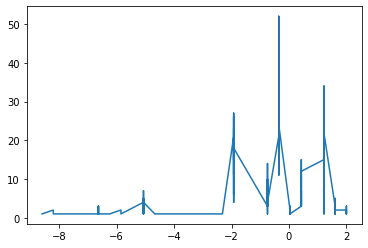

In [92]:
x = np.array(x)
y = np.array(y)

ind = np.argsort(x)
x = x[ind]
y = y[ind]

plt.plot(x,y)
plt.show()

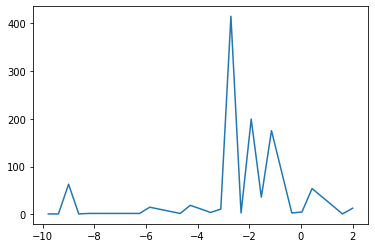

In [93]:
measurements = []
for key,value in res.items():
    key_ = key[sim:]
    eigenstate = key[1:(sim)]
    eigenstate = eigenstate[::-1]
    decimal = 0
    for i,bit in enumerate(key_):
        decimal += int(bit)*2**(-i-1)
    if value != 0:
        measurements.append(np.array([eigenstate, Emax-decimal*2*np.pi/t, value]))

measurements = np.array(measurements)
x = measurements[:,1]
y = measurements[:,2]
idx = np.argsort(x)
x = x[idx]
y = y[idx]
eigdict = {}
for xi in x:
    eigdict[xi] = 0
for xi, yi in zip(x,y):
    eigdict[xi] += int(yi)

x = np.array(list(eigdict.keys())).astype(np.float)
idx = np.argsort(x)
y = np.array(list(eigdict.values())).astype(np.int)
x = x[idx]
y = y[idx]
plt.plot(x,y)
plt.show()